# Process Callback Duration Results

This generates callback duration plots from a set of `.csv` files. There is some basic filtering so heartbeats and callbacks which are never called are not included.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from typing import TypedDict

from helpers import prettify

pd.set_option("display.precision", 2)
pd.set_option("display.float_format", "{:,.2f}".format)

In [ ]:
path = "~/ros2_tracing_cpp/build/plugins/callback_duration_metadata.csv"
"""The location of the callback metadata summary CSV File"""

BUFFER_PERIOD = 15
"""Many callbacks take some time before doing any work, removing them"""

met_df = pd.read_csv(path)
met_df

,symbol,procname,address,count,path,avg_duration
0,std::_Bind<void (motion_planning::PathServer::...,path_server_nod,98404760672248,1,callback_98404760672248_path_server_nod.csv,0.00
1,std::_Bind<void (ControlManager::*(ControlMana...,control_node,95398100769096,1184,callback_95398100769096_control_node.csv,0.00
2,std::_Bind<void (motion_planning::PathServer::...,path_server_nod,98404761784576,1184,callback_98404761784576_path_server_nod.csv,0.00
3,std::_Bind<void (motion_planning::PathServer::...,path_server_nod,98404760275608,2829,callback_98404760275608_path_server_nod.csv,0.00
4,NaN,NaN,96301272021336,4046,callback_96301272021336_.csv,0.00
...,...,...,...,...,...,...
95,NaN,NaN,96301272087560,12361,callback_96301272087560_.csv,0.00
96,std::_Bind<void (tf2_ros::TransformListener::*...,path_server_nod,98404760469432,6468,callback_98404760469432_path_server_nod.csv,0.00
97,std::_Bind<void (control::LongControl::*(contr...,long_control_no,105105059107416,12360,callback_105105059107416_long_control_no.csv,0.00
98,std::_Bind<void (ControlManager::*(ControlMana...,control_node,95398101201448,6302,callback_95398101201448_control_node.csv,0.00


In [3]:
# basic filtering
more_than_filtering = met_df['count'] > 50
longer_than_1ms = met_df['avg_duration'] > 0.001

combined_filter = more_than_filtering
combined_filter &= longer_than_1ms

met_df = met_df.dropna()
met_df = met_df[combined_filter]
met_df['symbol'] = met_df['symbol'].apply(prettify)
met_df

/tmp/ipykernel_2155763/3450280431.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  met_df = met_df[combined_filter]


,symbol,procname,address,count,path,avg_duration
15,motion_planning::trajectory_planner::Trajector...,trajectory_plan,102019829820808,3071,callback_102019829820808_trajectory_plan.csv,0.02
51,ControlManager::?\n(),control_node,95398101546080,6346,callback_95398101546080_control_node.csv,0.01


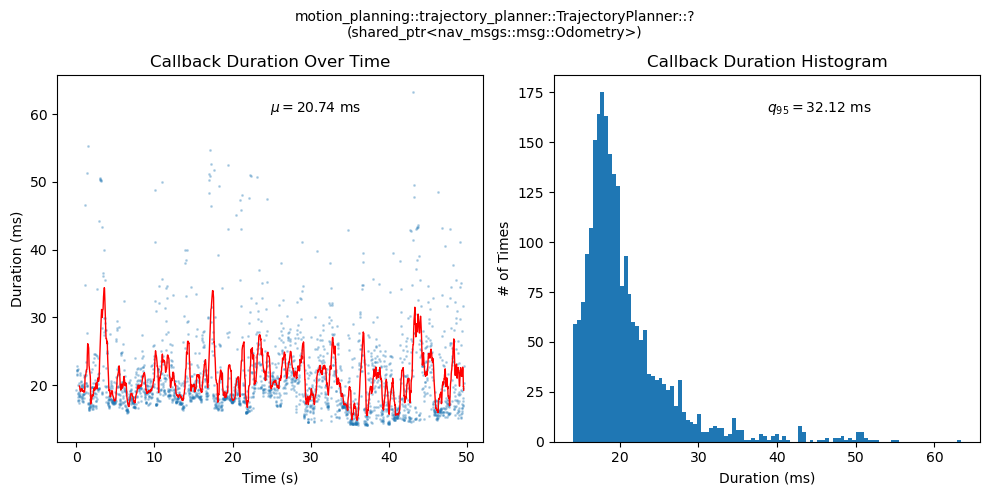

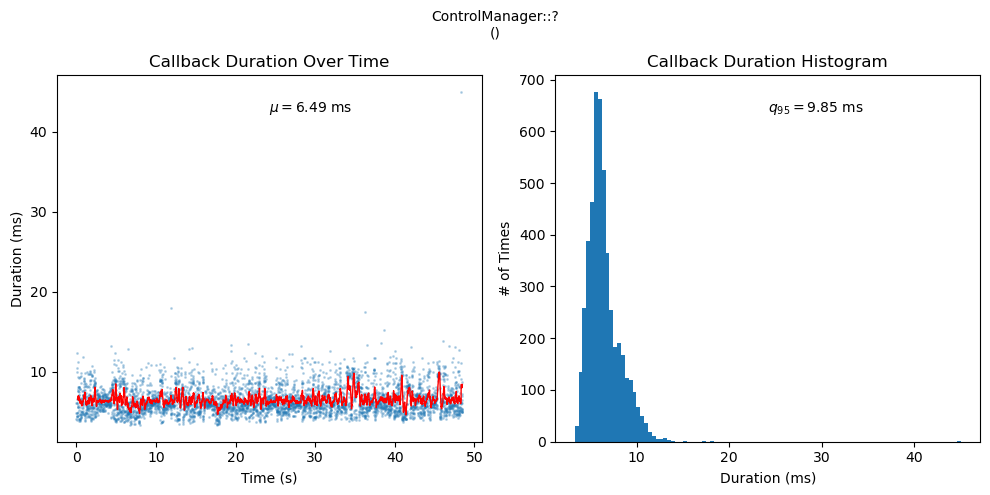

,procname,symbol,mu,q50,q95,q99,q999,q9999
0,trajectory_plan,motion_planning::trajectory_planner::Trajector...,20.74,19.03,32.12,48.14,53.97,61.41
1,control_node,ControlManager::?\n(),6.49,6.11,9.85,11.36,13.57,31.94


In [4]:
class LatencyStatistics(TypedDict):
    """
    Latency summary statistics
    """

    procname: str
    """Process name"""
    symbol: str
    """Callback symbol"""
    mu: float
    """Mean latency"""
    q50: float
    """Median latency"""
    q95: float
    """95th quartile latency"""
    q99: float
    """99th quartile latency"""
    q999: float
    """99.9th quartile latency"""
    q9999: float
    """99.99th quartile latency"""


def calculate_latency_statistics(df: pd.DataFrame) -> LatencyStatistics:
    """
    Helper function to calculate the latency statistics from a dataframe

    :param pd.DataFrame df: The dataframe to aggregate
    """

    duration = df["duration"]

    mu = duration.mean()
    q50 = duration.quantile(0.50)
    q95 = duration.quantile(0.95)
    q99 = duration.quantile(0.99)
    q999 = duration.quantile(0.999)
    q9999 = duration.quantile(0.9999)

    return dict(mu=mu, q50=q50, q95=q95, q99=q99, q999=q999, q9999=q9999)


def make_graph(row: dict, window_size: int = 20) -> LatencyStatistics:
    """
    Makes a graph for a particular plot and symbol name

    :param dict row: the row of the `met_df` table
    :param int window_size: the size of the rolling average to take
    """

    path_dir = os.path.dirname(path)
    data_path = os.path.join(path_dir, row["path"])
    df = pd.read_csv(data_path, skiprows=2)

    # turn time in nsecs from the origin into datatime
    min_time = df["time"].min()
    df["time"] = df["time"] - min_time
    df["time"] /= 1e9  # turning time into seconds
    df["time"] -= BUFFER_PERIOD
    df = df[df["time"] > 0]

    df["duration"] /= 1e6  # turning duration into miliseconds

    rolling_avg = np.convolve(
        np.array(df["duration"]), np.ones(window_size) / window_size, mode="valid"
    )

    # plotting figures
    fig, (ax_duration, ax_hist) = plt.subplots(1, 2, figsize=(10, 5))

    ax_duration.scatter(
        df["time"],
        df["duration"],
        s=1.25,
        alpha=0.25,
    )
    ax_duration.plot(
        np.array(df["time"])[window_size - 1 :],
        rolling_avg,
        color="red",
        linewidth=1,
        label="Rolling Average",
    )
    ax_duration.set_title("Callback Duration Over Time")
    ax_duration.set_xlabel("Time (s)")
    ax_duration.set_ylabel("Duration (ms)")
    ax_duration.text(
        0.5,
        0.9,
        f"$\mu={df['duration'].mean():.2f}$ ms",
        fontsize=10,
        transform=ax_duration.transAxes,
    )

    # histogram
    ax_hist.hist(df["duration"], bins=100)
    ax_hist.set_title("Callback Duration Histogram")
    ax_hist.set_xlabel("Duration (ms)")
    ax_hist.set_ylabel("# of Times")
    ax_hist.text(
        0.5,
        0.9,
        f"$q_{{95}}={df['duration'].quantile(0.95):.2f}$ ms",
        fontsize=10,
        transform=ax_hist.transAxes,
    )

    fig.suptitle(row["symbol"], fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    # returning latency statistics
    return dict(
        procname=row["procname"], symbol=row["symbol"]
    ) | calculate_latency_statistics(df)

summary_df = pd.DataFrame(met_df.apply(make_graph, axis=1).to_list()).sort_values(
    by=["q9999"], ascending=[False]
)

summary_df